# Magnetic field sources

The `superscreen.sources` module contains functions that can be used to generate several common types of applied magnetic fields for use in `SuperScreen` simulations:

- `sources.ConstantField`: A spatially uniform out-of-plane field, $\mu_0H_z(\vec{r})=\text{const.}$


- `sources.Monopolefield` (also aliased as `sources.VortexField`): The $z$-component of the field from a magnetic monopole with a given magnetic charge. If the magnetic charge is $\Phi_0=h/(2e)$, then this is an approximation for the field from a vortex trapped in a bulk superconductor with a small London penetration depth. For a monopole with magnetic charge $n\Phi_0$ located at position $\vec{r}_0=(x_0, y_0, z_0)$, the $z$-component of the magnetic field at position $\vec{r}=(x, y, z)$ is given by:
    $$\mu_0H_z(\vec{r})=\frac{n\Phi_0}{2\pi}\frac{(\vec{r}-\vec{r}_0)\cdot\hat{z}}{|\vec{r}-\vec{r}_0|^3}.$$


- `sources.PearlVortexField`: The $z$-component of the magnetic field at position $\vec{r}=(x, y, z)$ from a Pearl vortex trapped at the origin in a superconducting film with Pearl length $2\Lambda$:
    $$\mu_0 H_z(\vec{r}) = \mathcal{F}^{-1}\left\{\mathcal{F}\{\mu_0 H_z\}(k_x, k_y, z)\right\} = \mathcal{F}^{-1}\left\{\frac{n\Phi_0 e^{-kz}}{1 + 2\Lambda k}\right\},$$

  where $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the 2D Fourier transform and inverse Fourier transform, and $k_x$ and $k_y$ are spatial frequencies with $k\equiv\sqrt{k_x^2 + k_y^2}$. See [Physical Review Letters 92, 157006 (2004)](https://doi.org/10.1103/PhysRevLett.92.157006) (full text PDF [here](https://art.torvergata.it/retrieve/handle/2108/33451/53023/PRL%20Tafuri%202004.pdf)).


- `sources.DipoleField`: The magnetic field from a distribution of magnetic dipoles. For a set of magnetic dipoles with moments $\vec{m}_i$ located at positions $\vec{r}_{0, i}=(x_i, y_i, z_i)$, the vector magnetic field at position $\vec{r}=(x, y, z)$ is given by: 
    $$
        \mu_0\vec{H}(\vec{r}) = \sum_i\frac{\mu_0}{4\pi}
            \frac{3\hat{r}_i(\hat{r}_i\cdot\vec{m}_i) - \vec{m}_i}{|\vec{r}_i|^3},
    $$

  where $\vec{r}_i=\vec{r} - \vec{r}_{0, i}$.


- `sources.SheetCurrentField`: The $z$-component of the field from a 2D sheet of current $S$ lying in the plane $z=z_0$  with spatially varying current density $\vec{J}=(J_x, J_y)$.
    $$\mu_0H_z(\vec{r})=\frac{\mu_0}{2\pi}\int_S\frac{J_x(\vec{r}')(\vec{r}-\vec{r}')\cdot\hat{y} - J_y(\vec{r}')(\vec{r}-\vec{r}')\cdot\hat{x}}{|\vec{r}-\vec{r}'|^3}\,\mathrm{d}^2r',$$

  where $\vec{r}=(x, y, z)$ and $\vec{r}'=(x', y', z_0)$.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

import superscreen as sc

## `ConstantField`

$\mu_0H_z(x, y, z)=\text{const.}$ for any $x, y, z$.

In [2]:
field = sc.sources.ConstantField(5)
print(field)

Parameter<constant(value=5.0)>


In [3]:
x, y, z = np.random.rand(3)
print(
    "\n".join(
        [f"x = {x}", f"y = {y}", f"z = {z}", f"field(x, y, z) = {field(x, y, z)}"]
    )
)

x = 0.4582855068371203
y = 0.8474711047704706
z = 0.197675170059728
field(x, y, z) = 5.0


In [4]:
x, y, z = np.random.rand(3 * 100).reshape((3, 100))
Hz = field(x, y, z)
assert Hz.shape == x.shape == y.shape == z.shape
assert field.kwargs == {"value": 5.0}
assert np.all(Hz == field.kwargs["value"])

## `MonopoleField` (i.e. `VortexField`)

Here we calculcate the field from a magnetic monopole with magnetic charge $q=\Phi_0$ located at $x = y = z = 0$. Note that `VortexField` is simply an alias for `MonopoleField`.

In [5]:
assert sc.sources.VortexField is sc.sources.MonopoleField

In [6]:
field = sc.sources.VortexField(r0=(0, 0, 0), nPhi0=1)
print(field)

Parameter<monopole(r0=(0, 0, 0), nPhi0=1)>


Below we evaluate $\mu_0H_z(0, 0, z)$, the magnetic field as a function of height directly above the monopole.

In [7]:
N = 101
eval_xs = eval_ys = np.zeros(N)
eval_zs = np.linspace(0.1, 1, N)
Hz = field(eval_xs, eval_ys, eval_zs) * sc.ureg("Phi_0 / um ** 2")

Text(0, 0.5, '$\\mu_0H_z(0, 0, z)$ [$\\Phi_0$ / $\\mu\\mathrm{m}^2$]')

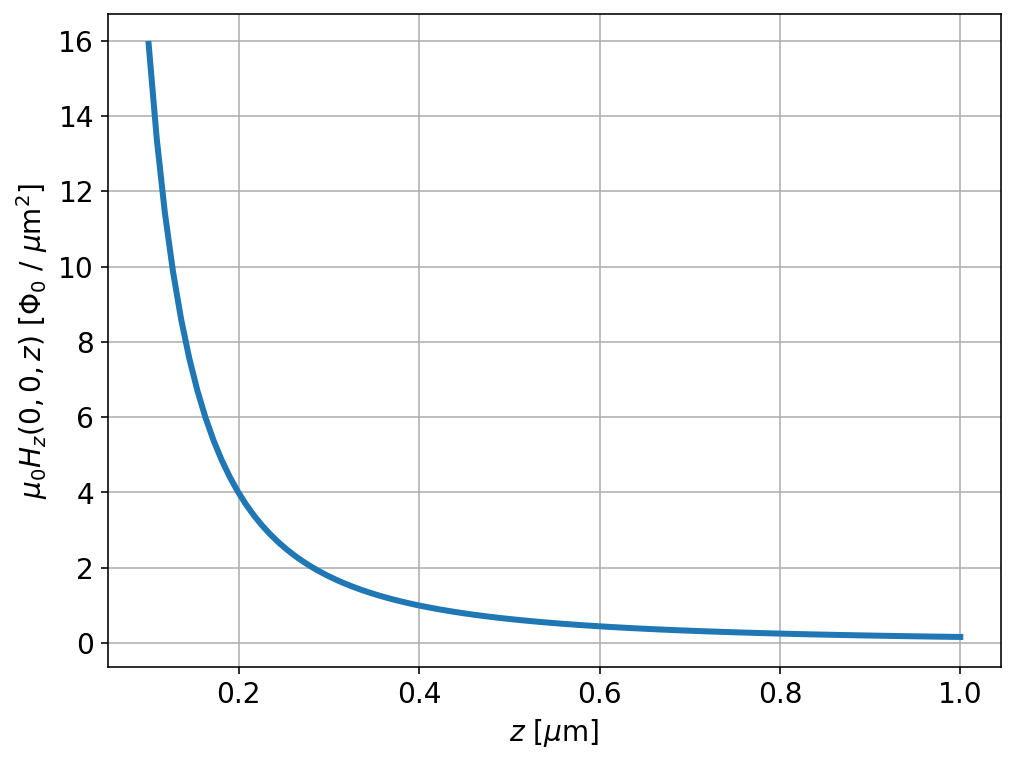

In [8]:
fig, ax = plt.subplots()
ax.plot(eval_zs, Hz.magnitude, lw=3)
ax.grid(True)
ax.set_xlabel("$z$ [$\\mu\\mathrm{m}$]")
ax.set_ylabel("$\\mu_0H_z(0, 0, z)$ [$\\Phi_0$ / $\\mu\\mathrm{m}^2$]")

Here we evaluate the field $\mu_0H_z(x, y, 0.1\,\mu\mathrm{m})$ on a grid (2D):

In [9]:
# Coordinates at which to evaluate the magnetic field (in microns)
N = 101
eval_xs = eval_ys = np.linspace(-1, 1, N)
eval_z = 0.1
xgrid, ygrid, zgrid = np.meshgrid(eval_xs, eval_ys, eval_z)
xgrid = np.squeeze(xgrid)
ygrid = np.squeeze(ygrid)
zgrid = np.squeeze(zgrid)

# field returns shape (N * N, ) and the units are Phi_0 / length_units ** 2
Hz = field(xgrid.ravel(), ygrid.ravel(), zgrid.ravel()) * sc.ureg("Phi_0 / um ** 2")
# Reshape to (N, N) and convert to mT
Hz = Hz.reshape((N, N)).to("mT").magnitude

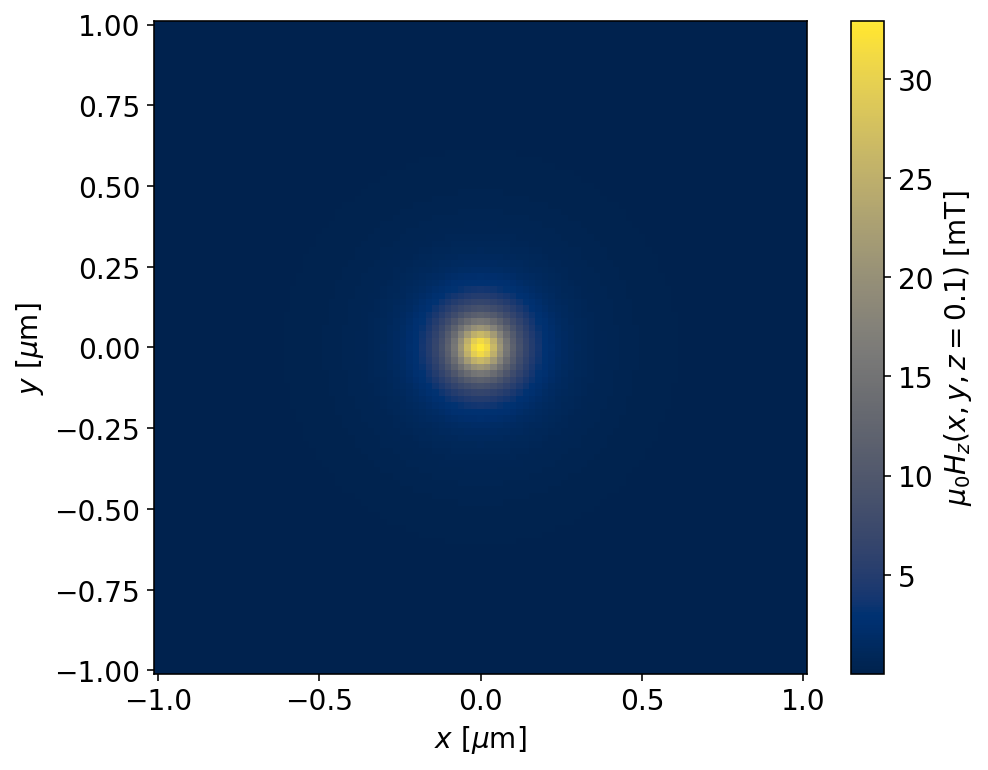

In [10]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
im = ax.pcolormesh(xgrid, ygrid, Hz, shading="auto", cmap="cividis")
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$x$ [$\\mu$m]")
ax.set_ylabel("$y$ [$\\mu$m]")
cbar.set_label(f"$\\mu_0H_z(x, y, z={{{eval_z}}})$ [mT]")

## `PearlVortexField`

The magnetic field from a Pearl vortex is calculated using a 2D Fourier transform as described above. See [Physical Review Letters 92, 157006 (2004)](https://doi.org/10.1103/PhysRevLett.92.157006) (full text PDF [here](https://art.torvergata.it/retrieve/handle/2108/33451/53023/PRL%20Tafuri%202004.pdf)).

Below we calculcate the magnetic field from a Pearl vortex trapped at the origin in a superconducting film with effective penetration depth $\Lambda = 1\,\mu\mathrm{m}$ (Pearl length $2\Lambda=2\,\mu\mathrm{m}$).

In [11]:
# Define the domain over which 2D Fourier transform will be performed.
xs = ys = np.linspace(-5, 5, 301)
field = sc.sources.PearlVortexField(r0=(0, 0, 0), xs=xs, ys=ys, nPhi0=1, Lambda=1)

# Coordinates at which to evaluate the magnetic field (in microns)
N = 101
eval_xs = eval_ys = np.linspace(-1, 1, N)
eval_z = 0.1
xgrid, ygrid, zgrid = np.meshgrid(eval_xs, eval_ys, eval_z)
xgrid = np.squeeze(xgrid)
ygrid = np.squeeze(ygrid)
zgrid = np.squeeze(zgrid)

# field returns shape (N * N, ) and the units are Phi_0 / length_units ** 2
Hz = field(xgrid.ravel(), ygrid.ravel(), zgrid.ravel()) * sc.ureg("Phi_0 / um ** 2")
# Reshape to (N, N) and convert to mT
Hz = Hz.reshape((N, N)).to("mT").magnitude

Plot the resulting field profile:

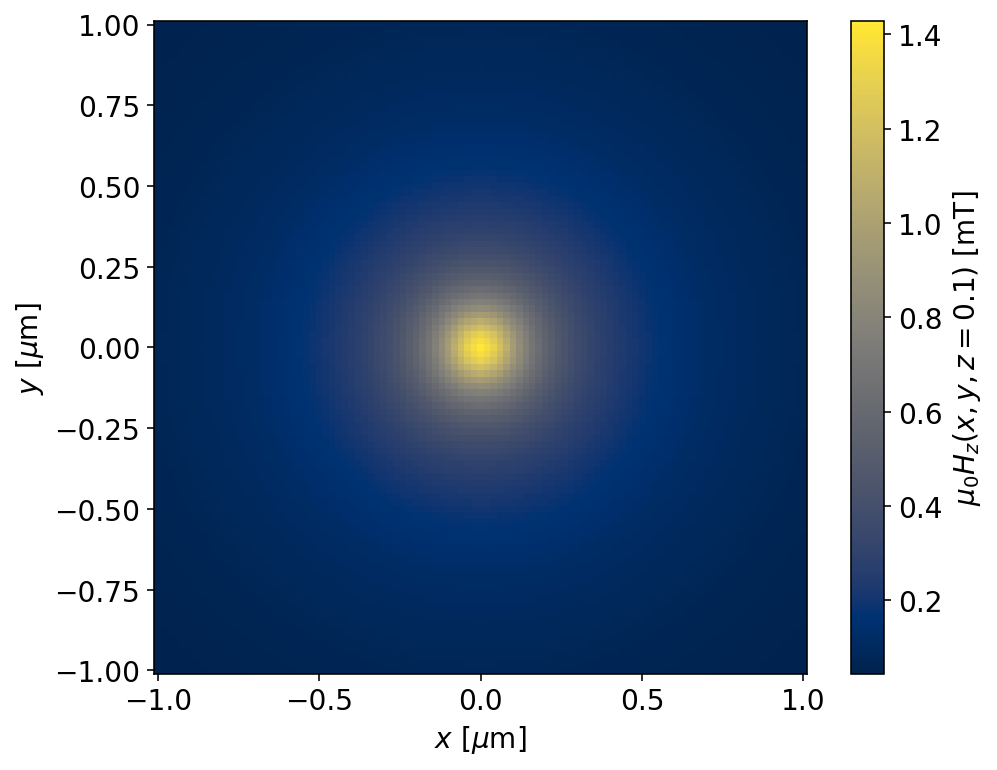

In [12]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
im = ax.pcolormesh(xgrid, ygrid, Hz, shading="auto", cmap="cividis")
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$x$ [$\\mu$m]")
ax.set_ylabel("$y$ [$\\mu$m]")
cbar.set_label(f"$\\mu_0H_z(x, y, z={{{eval_z}}})$ [mT]")

Below we look at cross-sections of the Pearl vortex field profile as a function of $\Lambda$.

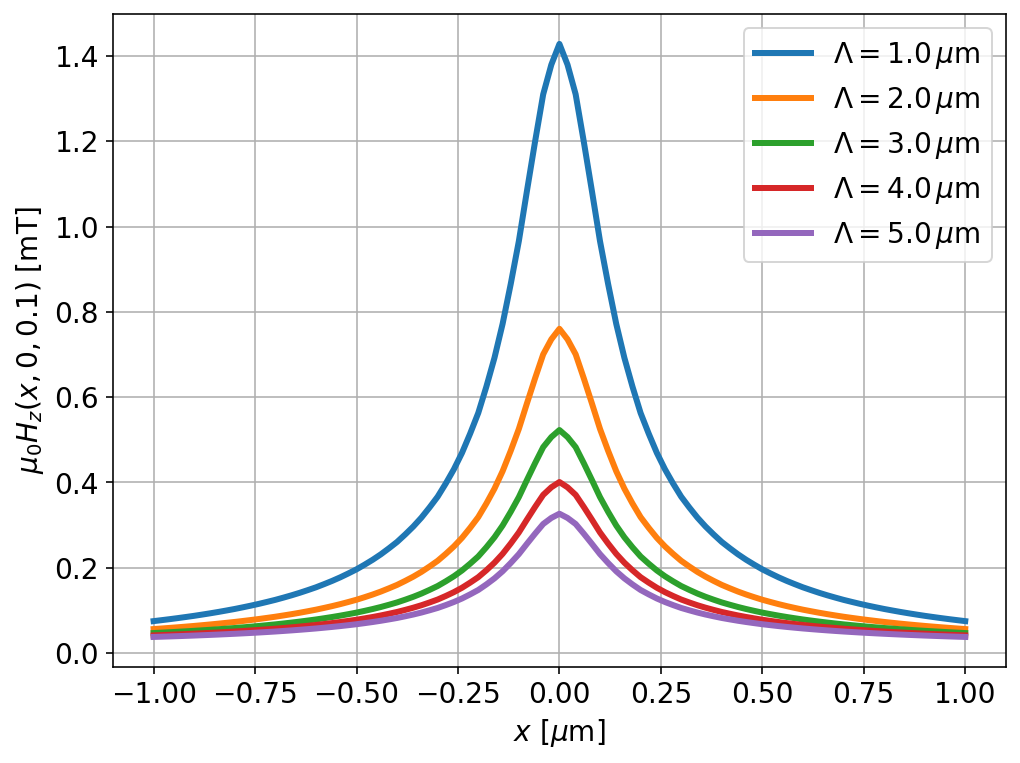

In [13]:
Lambdas = range(1, 6)

eval_xs = np.linspace(-1, 1, 101)
eval_ys = np.zeros_like(eval_xs)
eval_zs = 0.1 * np.ones_like(eval_xs)

field = sc.sources.PearlVortexField(xs=xs, ys=ys)

fig, ax = plt.subplots()
ax.grid(True)
for Lambda in Lambdas:
    field.kwargs["Lambda"] = Lambda
    Hz = field(eval_xs, eval_ys, eval_zs) * sc.ureg("Phi_0 / um ** 2")
    Hz = Hz.to("mT").magnitude
    ax.plot(eval_xs, Hz, lw=3, label=f"$\\Lambda={{{Lambda:.1f}}}\\,\\mu\\mathrm{{m}}$")

ax.set_xlabel("$x$ [$\\mu$m]")
ax.set_ylabel("$\\mu_0H_z(x, 0, 0.1)$ [mT]")
ax.legend(loc=0)

## `DipoleField`

Here we calculcate the field from a single magnetic dipole at the origin with dipole moment $\vec{m}=(m_x, m_y, m_z)=(0, 0, 1)\:\mu\mathrm{A}\cdot\mu\mathrm{m}^2$.

In [14]:
field = sc.sources.DipoleField(
    dipole_positions=(0, 0, 0),
    dipole_moments=(0, 0, 1),
    moment_units="uA * um ** 2",
    length_units="um",
)

# Coordinates at which to evaluate the magnetic field (in microns)
N = 101
eval_xs = eval_ys = np.linspace(-1, 1, N)
eval_z = 0.5
xgrid, ygrid, zgrid = np.meshgrid(eval_xs, eval_ys, eval_z)
xgrid = np.squeeze(xgrid)
ygrid = np.squeeze(ygrid)
zgrid = np.squeeze(zgrid)

# field returns shape (N * N, 3), where the last axis is field component
# and the units are Tesla
Hz = field(xgrid.ravel(), ygrid.ravel(), zgrid.ravel()) * sc.ureg("tesla")

# Reshape to (N, N, 3), where the last axis is field component,
# and convert to microTesla
Hz = Hz.reshape((N, N, 3)).to("microtesla").magnitude

Plot the resulting vector magnetic field:

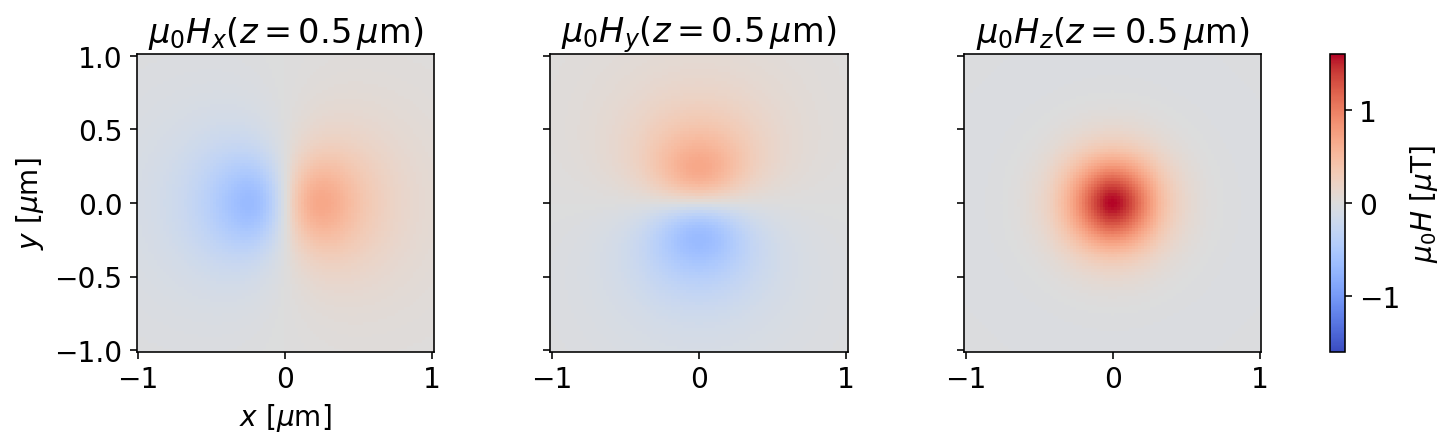

In [15]:
fig, axes = plt.subplots(
    1, 3, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True
)

vmax = max(abs(Hz.min()), abs(Hz.max()))
vmin = -vmax
kwargs = dict(vmin=vmin, vmax=vmax, shading="auto", cmap="coolwarm")

for i, (ax, label) in enumerate(zip(axes, "xyz")):
    ax.set_aspect("equal")
    im = ax.pcolormesh(xgrid, ygrid, Hz[..., i], **kwargs)
    ax.set_title(f"$\\mu_0H_{{{label}}}(z={{{eval_z}}}\\,\\mu\\mathrm{{m}})$")
cbar = fig.colorbar(im, ax=axes)
cbar.set_label("$\\mu_0H$ [$\\mu$T]")
_ = axes[0].set_xlabel("$x$ [$\\mu$m]")
_ = axes[0].set_ylabel("$y$ [$\\mu$m]")

`superscreen.sources.DipoleField` also supports distributions of magnet dipoles, which can be used to model the field from a continuous magnetic structure. For example, here we calculate the vector magnetic field from a magnetic "+" lying in the $x-y$ plane with uniform out-of-plane magnetization. We'll assume that the dimensions of the "+" are in microns and that its magnetization (area density of magnetic moments) is $\vec{m}=1\,\mu_\mathrm{B}/\mathrm{nm}^2\,\hat{z}$, where $\mu_\mathrm{B}$ is the Bohr magneton.

In [16]:
# Generate the mesh
bar = sc.Polygon(points=sc.geometry.box(10, 2))
plus = bar.union(bar.rotate(90))

points, triangles = plus.make_mesh(min_points=1500)
x, y = points[:, 0], points[:, 1]

# (x, y, z) position of each vertex
vertex_positions = np.stack([x, y, np.zeros_like(x)], axis=1)

# Calculate the effective area of each vertex in the mesh
vertex_areas = sc.fem.mass_matrix(points, triangles) * sc.ureg("um ** 2")

# Define the magnetic moment of each mesh vertex
z_hat = np.array([0, 0, 1])  # unit vector in the z direction
magnetization = sc.ureg("1 mu_B / nm ** 2")
vertex_moments = z_hat * magnetization * vertex_areas[:, np.newaxis]
# Convert to units of Bohr magnetons
vertex_moments = vertex_moments.to("mu_B").magnitude

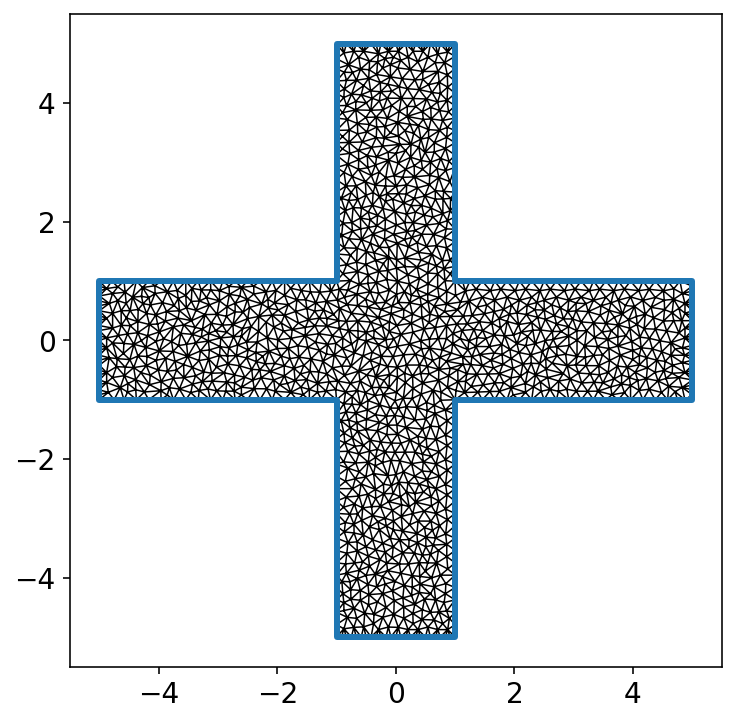

In [17]:
ax = plus.plot(lw=3)
_ = ax.triplot(x, y, triangles, color="k", lw=0.75)

Calculate the field using `superscreen.sources.DipoleField`:

In [18]:
field = sc.sources.DipoleField(
    dipole_positions=vertex_positions,
    dipole_moments=vertex_moments,
)

# Coordinates at which to evaluate the magnetic field (in microns)
N = 101
eval_xs = eval_ys = np.linspace(-6, 6, N)
eval_z = 0.5
xgrid, ygrid, zgrid = np.meshgrid(eval_xs, eval_ys, eval_z)
xgrid = np.squeeze(xgrid)
ygrid = np.squeeze(ygrid)
zgrid = np.squeeze(zgrid)

# field returns shape (N * N, 3), where the last axis is field component
# and the units are Tesla
Hz = field(xgrid.ravel(), ygrid.ravel(), zgrid.ravel()) * sc.ureg("tesla")
# Reshape to (N, N, 3), where the last axis is field component,
# and convert to microTesla
Hz = Hz.reshape((N, N, 3)).to("microtesla").magnitude

Plot the results:

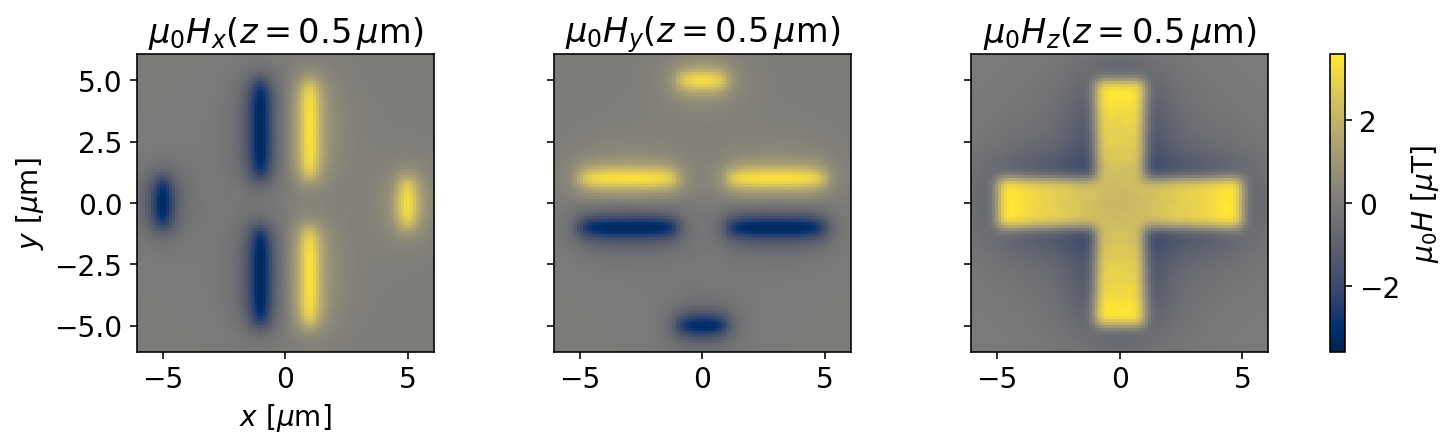

In [19]:
fig, axes = plt.subplots(
    1, 3, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True
)

vmax = max(abs(Hz.min()), abs(Hz.max()))
vmin = -vmax
kwargs = dict(vmin=vmin, vmax=vmax, shading="auto", cmap="cividis")

for i, (ax, label) in enumerate(zip(axes, "xyz")):
    ax.set_aspect("equal")
    im = ax.pcolormesh(xgrid, ygrid, Hz[..., i], **kwargs)
    ax.set_title(f"$\\mu_0H_{{{label}}}(z={{{eval_z}}}\\,\\mu\\mathrm{{m}})$")
cbar = fig.colorbar(im, ax=axes)
cbar.set_label("$\\mu_0H$ [$\\mu$T]")
_ = axes[0].set_xlabel("$x$ [$\\mu$m]")
_ = axes[0].set_ylabel("$y$ [$\\mu$m]")

## `SheetCurrentField`

Below we calculate the magnetic field from a $1\,\mu\mathrm{m}$ wide wire lying along the $x$-axis and carrying a current density of $\vec{J}=1\,\mathrm{mA}/\mu\mathrm{m}\:\hat{x}$ (total current $I=1\,\mathrm{mA}$).

Define the wire geometry and specify the current density $\vec{J}(x, y)=(J_x, J_y)$:

In [20]:
wire = sc.Polygon(points=sc.geometry.box(12, 1))
points, _ = wire.make_mesh(min_points=2000)

current_densities = np.array([1, 0]) * np.ones((points.shape[0], 1))

Calculate the field using `superscreen.sources.SheetCurrentField`:

In [21]:
field = sc.sources.SheetCurrentField(
    sheet_positions=points,
    current_densities=current_densities,
    z0=0,
    length_units="um",
    current_units="mA",
)

# Coordinates at which to evaluate the magnetic field (in microns)
N = 101
eval_xs = eval_ys = np.linspace(-5, 5, N)
eval_z = 0.5
xgrid, ygrid, zgrid = np.meshgrid(eval_xs, eval_ys, eval_z)
xgrid = np.squeeze(xgrid)
ygrid = np.squeeze(ygrid)
zgrid = np.squeeze(zgrid)

# field returns shape (N * N, ) and the units are tesla
Hz = field(xgrid.ravel(), ygrid.ravel(), zgrid.ravel()) * sc.ureg("tesla")
# Reshape to (N, N) and convert to mT
Hz = Hz.reshape((N, N)).to("mT").magnitude

Plot the field and a cross-section along the $y$-axis:

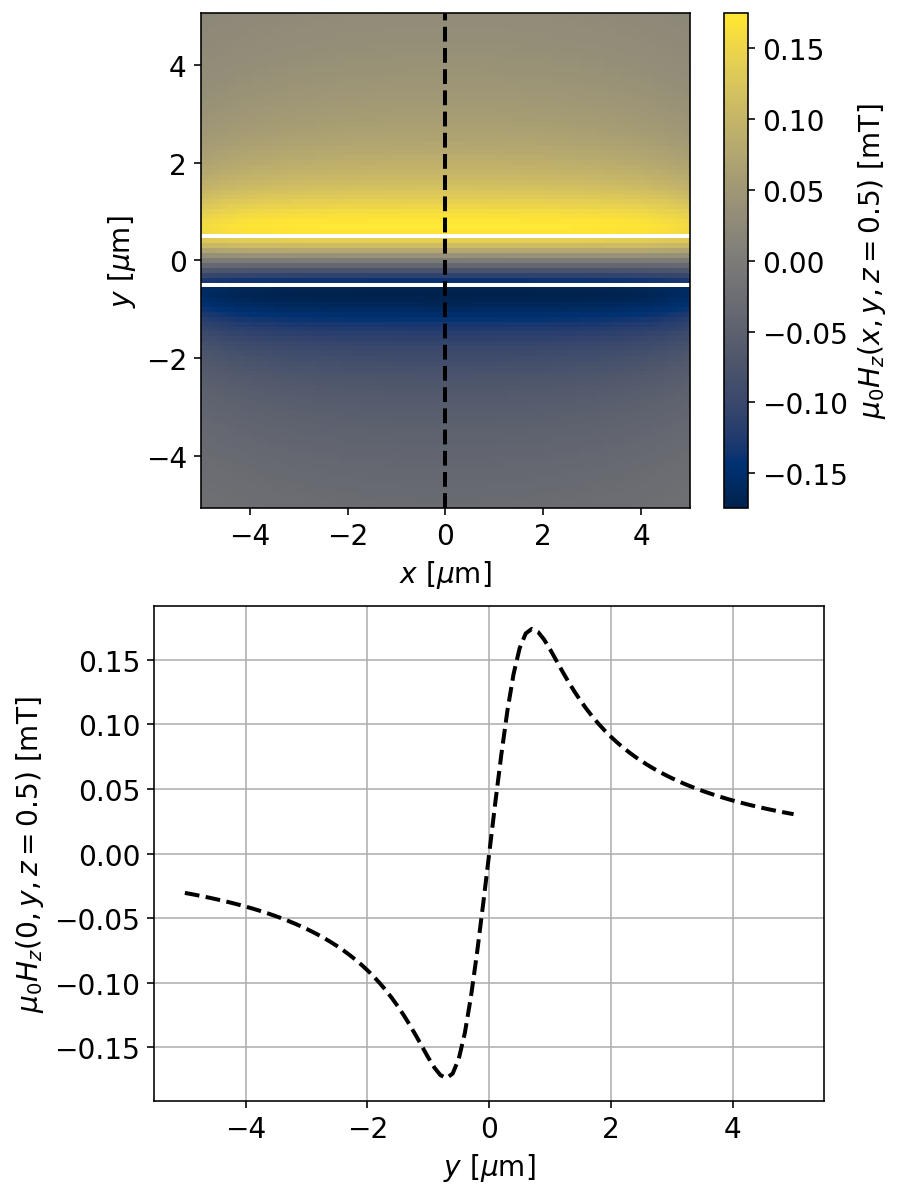

In [22]:
fig, (ax, bx) = plt.subplots(2, 1, figsize=(6, 10))
ax.set_aspect("equal")
im = ax.pcolormesh(xgrid, ygrid, Hz, shading="auto", cmap="cividis")
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$x$ [$\\mu$m]")
ax.set_ylabel("$y$ [$\\mu$m]")
cbar.set_label(f"$\\mu_0H_z(x, y, z={{{eval_z}}})$ [mT]")
wire.plot(ax=ax, color="w", lw=2)
ax.set_xlim(-5, 5)
ax.axvline(0, color="k", ls="--", lw=2)

bx.plot(eval_ys, Hz[:, np.argmin(np.abs(eval_xs))], "k--", lw=2)
bx.set_xlabel("$y$ [$\\mu$m]")
bx.set_ylabel(f"$\\mu_0H_z(0, y, z={{{eval_z}}})$ [mT]")
bx.grid(True)

In [23]:
sc.version_table()

Software,Version
SuperScreen,0.4.0
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS
